# Gaussian mixture model background subtraction for _in situ_ XRD

Using cycad for easy file import but can also use standard dataframe

In [31]:
from cycad import cycad
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from ipywidgets import interact, interactive, fixed, interact_manual
from sklearn.mixture import GaussianMixture
import pandas as pd

Here we instantiate a cycad object, and load data to the cycad.df dataframe.

Todo: work out why file loading speed is highly inconsistent (should be very fast in ideal case)

In [2]:
# Instantiate cycad object
frames = cycad()

# Load data folder and read data 
data_folder = 's02_r05'
frames.read_folder(data_folder, 'xye')

# # Restrict data range for XRD data
# frames.df = frames.df[200:1600].reset_index(drop=True)


100%|██████████| 2224/2224 [00:03<00:00, 628.53it/s]


Plot data to make sure it's what we expect.
so2_r05 is metal additive manufacturing XRD data
- Phase of interest is aluminium which undergoes a small thermal expansion
- Beryllium and substrate peaks in background

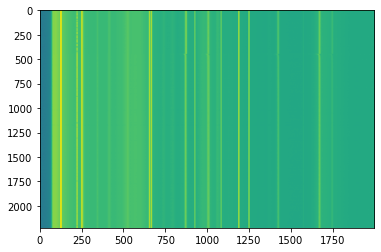

In [3]:
plt.imshow(frames.df.T, aspect='auto', norm=LogNorm())
plt.show()

<AxesSubplot:>

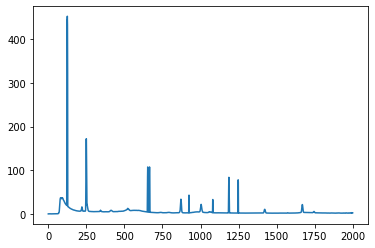

In [157]:
# Plot a single frame to check diffraction looks normal
frames.df.T.iloc[10].plot()
# plt.xlim(850,900)

#### Procedure
1. Get each row of data (one x-axis bin)
2. Fit a 2-component GMM to each position
3. Subtract the first GMM component from the raw data

First transpose the dataframe and plot a row (one point from each in situ frame) as a sanity check.

Here position 872 overlaps an aluminium peak that moves as the material is heated by laser

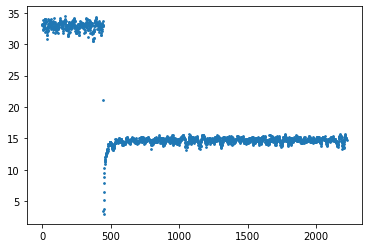

In [160]:
# Re-orient and drop X column
frames_gmm = frames.df.T[1:]

# drop dataframe index
frames_gmm = frames_gmm.reset_index(drop=True)

# Plot a row - expect to see mostly flat curve with changes where the position overlaps changing features
plt.scatter(range(frames_gmm.shape[0]), frames_gmm[872], s=3)

We use stripplot and violinplot to plot the data distribution at each point.

Stripplot show every value for a position, i.e. every intensity value in the plot above.

If we plot the data distribution at each in the frame, we can see regions with a single cluster of points representing unchanging background, and multiple or broader clusters representing changes.

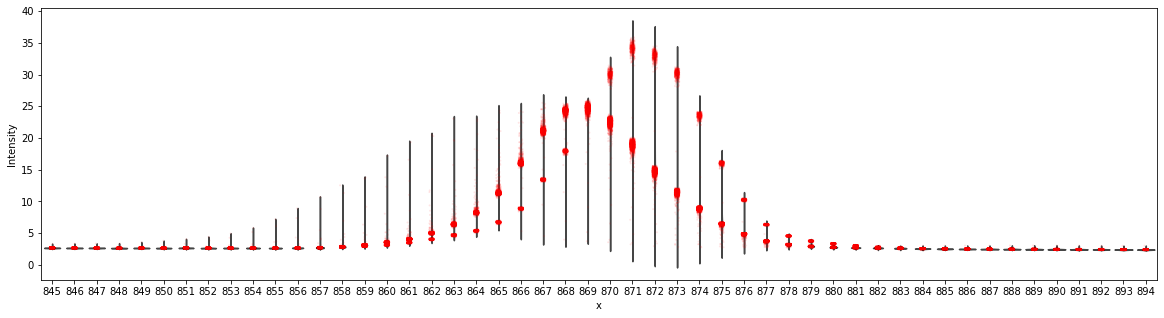

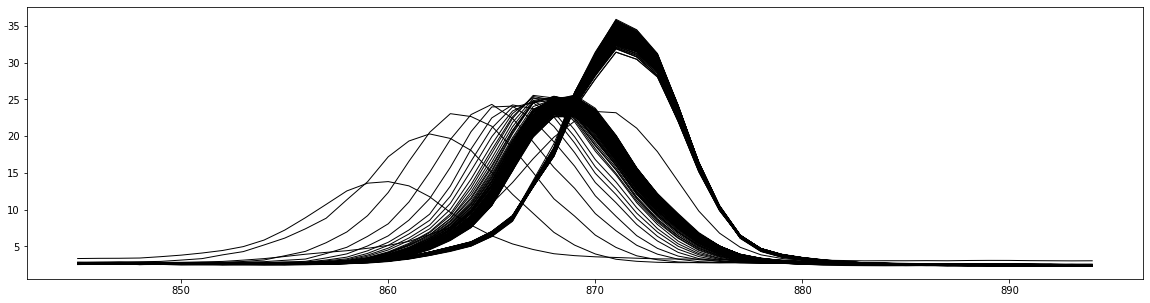

In [170]:
start, end = 845, 895

datalist = range(start,end)
new_data = pd.concat([frames_gmm[i] for i in datalist], axis=1)

plt.figure(figsize=(20,5))
sns.stripplot(data=new_data, color='red', size=2, alpha=0.1)
sns.violinplot(data=new_data, inner=None)
plt.xlabel('x')
plt.ylabel('Intensity')
plt.show()

plt.figure(figsize=(20,5))
plt.plot(frames_gmm.T[:][845:895], color='black', linewidth=1)
plt.show()

By fitting 2 (or more) Gaussian distributions to each position, you can capture the cluster means, the lower of which should correspond to the background.

First we define a function to fit a GMM with n components to each column of a dataframe, df

In [173]:
def gmm_background(n_components, df):
    gmm_means = df.apply(lambda x: GaussianMixture(n_components=n_components).fit(x.values.reshape(-1, 1)))
    gmm_means = gmm_means.apply(lambda x: x.means_.flatten())
    output = pd.DataFrame()
    for i in range(n_components):
        output[i] = gmm_means.apply(lambda x: x[i])
    return output

Then we run the function on our dataframe to obtain the GMM background

In [174]:
gmm_means = gmm_background(2, frames_gmm)
# gmm_means

,0,1
0,0.522176,0.006760
1,0.080833,0.361490
2,0.075895,0.263350
3,0.077223,0.222438
4,0.089812,0.214733
...,...,...
1995,1.801183,2.184280
1996,1.711279,2.141130
1997,1.569455,2.073418
1998,2.019838,1.401369


Plot the GMM components to check that they correspond to the background

We see that both components actually capture the static background, although the second component (orange) is messier around the changing peaks

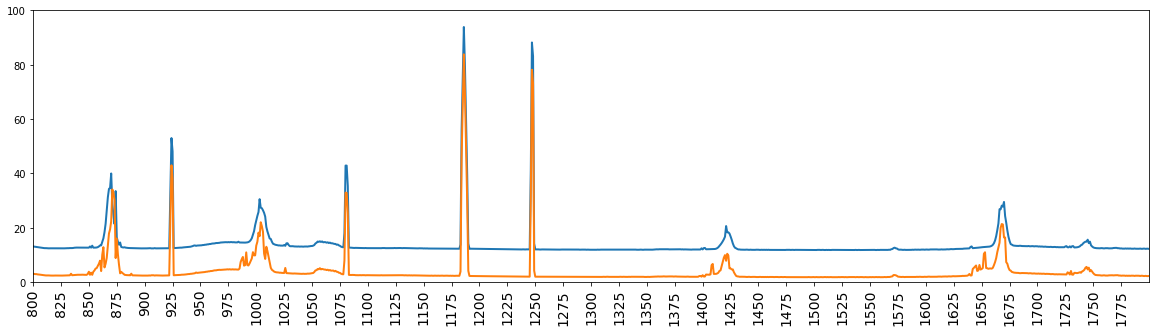

In [178]:
figure = plt.figure(figsize=(20, 5))
(gmm_means[0][:] + 10).plot(linewidth=2)
gmm_means[1][:].plot(linewidth=2)
plt.xlim(800, 1800)
plt.ylim(0, 100)
# minor ticks labels
plt.xticks(range(800, 1800, 25), fontsize=14, rotation=90)
plt.show()

We can directly subtract the first GMM component from the raw data

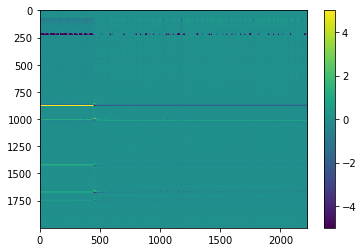

In [179]:
# Subtract background
frames_gmm_sub = frames_gmm - gmm_means[0]

# Plot GMM subtracted data
plt.imshow(frames_gmm_sub.T, aspect='auto', vmin=-5, vmax=5)
plt.colorbar()

Looking at the data more closely with the interactive plot below, it's clear that the GMM subtracted plot lead to negative intensities: as the peaks of interest don't move that much, there is always some intensity at some points within these peaks, which when subtracted from certain frames leads to negative intensity.

In [181]:
@interact
def plot_gmm(frame = (0, len(frames_gmm_sub)-1)):
    frames_gmm.iloc[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    plt.legend(['Original', 'GMM subtraction'])

    plt.xlim(800,1800)
    plt.ylim(-10, 40)

interactive(children=(IntSlider(value=1111, description='frame', max=2223), Output()), _dom_classes=('widget-i…

If we could replace those peaks in the GMM component with flat background, the subtraction would leave only the full peaks.

We can attempt this by manually identifying and fitting those peaks, then replacing those regions with background only. 

We can use popular peak fitting libary lmfit. First we fit an example peak:

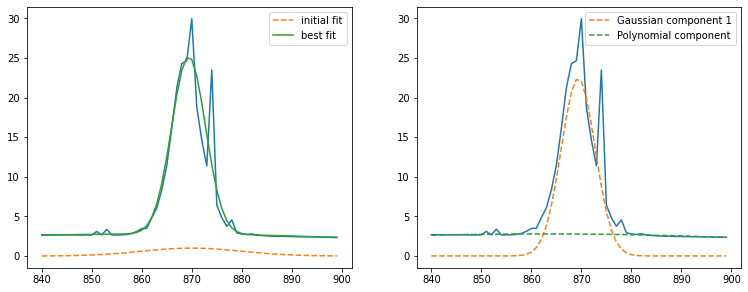

In [183]:
import lmfit
import numpy as np

from lmfit.models import GaussianModel, LinearModel, PolynomialModel

x = gmm_means[0][840:900].index
y = gmm_means[0][840:900]

lin_mod = LinearModel(prefix='lin_')
pars = lin_mod.guess(y, x=x)

poly_mod = PolynomialModel(2, prefix='poly_')
pars = poly_mod.guess(y, x=x, c0=0, c1=0, c2=0)

gauss1 = GaussianModel(prefix='g1_')
pars.update(gauss1.make_params())

pars['g1_center'].set(value=870, min=860, max=880)
pars['g1_sigma'].set(value=10, min=3)
pars['g1_amplitude'].set(value=25, min=10)

mod = gauss1 + poly_mod

init = mod.eval(pars, x=x)
out = mod.fit(y, pars, x=x)

# print(out.fit_report(min_correl=0.5))

fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
axes[0].plot(x, y)
axes[0].plot(x, init, '--', label='initial fit')
axes[0].plot(x, out.best_fit, '-', label='best fit')
axes[0].legend()

comps = out.eval_components(x=x)
axes[1].plot(x, y)
axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
# axes[1].plot(x, comps['lin_'], '--', label='Linear component')
axes[1].plot(x, comps['poly_'], '--', label='Polynomial component')
axes[1].legend()

plt.show()


Write this into a function:

In [184]:
from lmfit.models import GaussianModel, LinearModel

def peak2bkg(start, end, data, poly_n=2):
    x = data[start:end].index
    y = data[start:end]

    # lin_mod = LinearModel(prefix='lin_')
    # pars = lin_mod.guess(y, x=x)

    poly_mod = PolynomialModel(poly_n, prefix='poly_')
    pars = poly_mod.guess(y, x=x, c0=0, c1=0, c2=0)

    gauss1 = GaussianModel(prefix='g1_')
    pars.update(gauss1.make_params())

    pars['g1_center'].set(value=(end+start)//2, min=start, max=end)
    pars['g1_sigma'].set(value=(end-start)//4, min=1)
    pars['g1_amplitude'].set(value=y.max(), min=1)

    mod = gauss1 + poly_mod

    init = mod.eval(pars, x=x)
    out = mod.fit(y, pars, x=x)

    # print(out.fit_report(min_correl=0.5))

    # fig, axes = plt.subplots(1, 2, figsize=(12.8, 4.8))
    # axes[0].plot(x, y)
    # axes[0].plot(x, init, '--', label='initial fit')
    # axes[0].plot(x, out.best_fit, '-', label='best fit')
    # axes[0].legend()

    comps = out.eval_components(x=x)
    # axes[1].plot(x, y)
    # axes[1].plot(x, comps['g1_'], '--', label='Gaussian component 1')
    # axes[1].plot(x, comps['poly_'], '--', label='Polynomial component')
    # axes[1].legend()

    # plt.show()

    return comps['poly_']


Define a function to fit then remove peaks in user-defined regions:

In [185]:
# Define regions for peaks to be replaced with background
regions = [
    (850, 900),
    (980, 1025),
    (1400, 1440),
    (1650, 1680),
]

(0.0, 50.0)

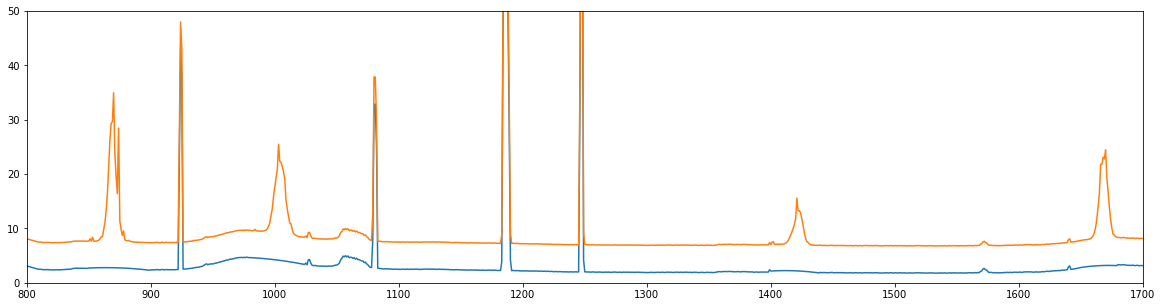

In [191]:
def peak_subtract(data, regions):
    data = data.copy()
    for start, end in regions:
        data[start:end] = peak2bkg(start, end, data)
    return data

gmm_mean_peakfit = peak_subtract(gmm_means[0], regions)

figure = plt.figure(figsize=(20, 5))
plt.plot(gmm_mean_peakfit)
plt.plot(gmm_means[0]+5)
plt.xlim(800, 1700)
plt.ylim(0, 50)

We can see that the peaks of interest are cleanly removed while leaving the rest of the background.

If we now subtract peak-corrected GMM component from raw data, the peaks of interest are retained:

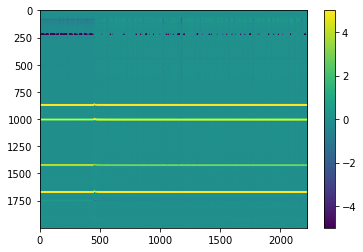

In [192]:
# Subtract background
frames_gmm_sub_peakfit = frames_gmm - gmm_mean_peakfit

# Plot corrected data
plt.imshow(frames_gmm_sub_peakfit.T, aspect='auto', vmin=-5, vmax=5)
plt.colorbar()

Show an interactive plot with the raw and subtracted data

In [195]:
@interact
def plot_gmm(frame = (0, len(frames_gmm_sub_peakfit)-1)):
    (frames_gmm.iloc[frame]+5).plot()
    frames_gmm_sub_peakfit.T[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    plt.legend(['Original', 'subtraction: GMM with peak removal', 'subtraction: GMM only'])

    plt.xlim(800,1800)
    plt.ylim(-10, 40)

interactive(children=(IntSlider(value=1111, description='frame', max=2223), Output()), _dom_classes=('widget-i…

Save a video for educational purposes:

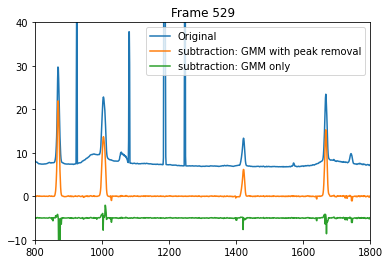

In [197]:
import matplotlib.animation as animation

fig, ax = plt.subplots()

def animate(frame):
    ax.clear()
    (frames_gmm.iloc[frame]+5).plot()
    frames_gmm_sub_peakfit.T[frame].plot()
    (frames_gmm_sub.T[frame] - 5).plot()
    ax.set_xlim(800,1800)
    ax.set_ylim(-10, 40)
    ax.set_title(f'Frame {frame}')
    ax.legend(['Original', 'subtraction: GMM with peak removal', 'subtraction: GMM only'])

ani = animation.FuncAnimation(fig, animate, frames=range(390, 530), interval=1)

ani.save('gmm_subtracted.mp4', writer='ffmpeg', fps=15, dpi=300)